In [1]:
import os
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
import Lasso.lasso_model as Lasso
import PCR.PCR_model as PCR
import Random_Forrest.rf_model as RF
import XGBoost.xgboost_model as XGBoost

#  Case Study: Forecasting Inflation During the COVID-19 Shock

This notebook presents a focused evaluation of model performance during the COVID-19 period. We simulate how different forecasting models would have predicted inflation for 2022, using only data available up to the end of 2021. The case study offers insights into how robust the models are under economic shocks and whether they provide valuable input for policy and forecasting in uncertain times.

## Structure of the Notebook

---

### 1. **Data and Preprocessing**
* Load and preprocess the macroeconomic dataset (`merged_dataset.csv`).
* Import inflation forecasts published by the **Danish National Bank** in **March 2022** and **September 2022**.
* **Target variable**: Year-over-year inflation.
* **Explanatory variables**: A comprehensive set of macroeconomic indicators.

### 2. **12-Month Ahead Forecast Case (Historical Simulation)**
For each point in time — **March 2022** and **September 2022** — the models produce 12-month-ahead inflation forecasts, which are compared to actual outcomes and the corresponding National Bank projections.

#### 2.1 Forecast Plots

* **Forecast from March 2022**: Models vs. National Bank forecast, for March 2022 to February 2023.
* **Forecast from September 2022**: Models vs. National Bank forecast, for September 2022 to August 2023.


#### 2.2 Forecast Evaluation

* Evaluate predictive performance for **each forecast origin** (March and September) using:

  * **Root Mean Squared Error (RMSE)**
  * **Mean Absolute Error (MAE)**
* Comparison of:
  * Each model’s forecast errors
  * National Bank’s forecast errors
---

## Objective of the Notebook

The goal is:  
**To demonstrate how machine learning forecasting models can be applied in practice to support economic decision-making during periods of uncertainty and structural change.**



# 1. Data and Preprocessing

In [5]:
# Navigate to data folder
os.chdir('Data')

# Load dataset and set 'Date' as index
file_path = 'merged_dataset.csv'
df = pd.read_csv(file_path, sep=';', parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Display dataset shape
print("Dataset shape:", df.shape)  # (rows, columns)

Dataset shape: (156, 220)


In [6]:
# Split into target (y) and features (X)
y = df.iloc[:, 0]   # First column = inflation (target variable)
X = df.iloc[:, 1:]  # Remaining columns = explanatory variables

# Print shapes
print("y shape:", y.shape)
print("X shape:", X.shape)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

y shape: (156,)
X shape: (156, 219)


### Inflation forecasts by the **Danish National Bank** 

In [8]:
file_path = 'Nb_forudsigelser.xlsx'
NB_forecast = pd.read_excel(file_path, header=0, decimal=",")
NB_forecast

,År,Forudsigelse,Horisont,Prognose udgivelse
0,2015,0.5,0,2015-03-01
1,2016,1.8,1,2015-03-01
2,2017,1.9,2,2015-03-01
3,2015,0.3,0,2015-09-01
4,2016,1.3,1,2015-09-01
...,...,...,...,...
58,2025,2.1,1,2024-09-01
59,2026,1.8,2,2024-09-01
60,2025,2.0,0,2025-03-01
61,2026,1.7,1,2025-03-01


# Functions

In [10]:
def run_all_forecasters(X, y, forecast_horizon, last_observation_date, scaler, trees, window_length=108, verbose=True):
    """
    Run LASSO, XGBoost, PCR, and Random Forest forecasters and combine their forecasts in one DataFrame.

    Args:
        X: DataFrame of predictors
        y: Series of the target variable
        forecast_horizon: int, number of steps ahead to forecast
        last_observation_date: str or pd.Timestamp, origin date for forecasting
        scaler: fitted sklearn scaler
        trees: int, number of trees for Random Forest
        window_length: int, size of the rolling window (default: 108 months)
        verbose: bool, whether to print model details
    Returns:
        pd.DataFrame with forecasts from all models and the true inflation values
    """

    # --- Run LASSO ---
    lasso_df = Lasso.lasso_forecast(
        X, y, 
        forecast_horizon=forecast_horizon, 
        last_observation_date=last_observation_date, 
        scaler=scaler, 
        window_length=window_length,
        verbose=verbose
    )
    lasso_df.rename(columns={"Inflation forecast": "LASSO"}, inplace=True)

    # --- Run XGBoost ---
    xgb_df = XGBoost.XGBoost_Forecaster(
        X, y, 
        forecast_horizon=forecast_horizon, 
        last_observation_date=last_observation_date, 
        scaler=scaler, 
        window_length=window_length,
        verbose=verbose
    )
    xgb_df.rename(columns={"Inflation forecast": "XGBoost"}, inplace=True)

    # --- Run PCR ---
    pcr_df = PCR.pcr_forecaster(
        X, y,
        forecast_horizon=forecast_horizon,
        last_observation_date=last_observation_date,
        scaler=scaler,
        variance_threshold=0.95,
        window_length=window_length,
        verbose=verbose
    )
    pcr_df.rename(columns={"Inflation forecast": "PCR"}, inplace=True)

    # --- Run Random Forest ---
    rf_df = RF.RandomForest_Forecaster(
        X, y,
        forecast_horizon=forecast_horizon,
        last_observation_date=last_observation_date,
        scaler=scaler,
        trees=trees,
        window_length=window_length,
        verbose=verbose
    )
    rf_df.rename(columns={"Inflation forecast": "RandomForest"}, inplace=True)

    # --- Merge all forecasts ---
    combined_df = lasso_df[["Date", "Horizon", "LASSO"]] \
        .merge(xgb_df[["Date", "Horizon", "XGBoost"]], on=["Date", "Horizon"]) \
        .merge(pcr_df[["Date", "Horizon", "PCR"]], on=["Date", "Horizon"]) \
        .merge(rf_df[["Date", "Horizon", "RandomForest"]], on=["Date", "Horizon"])

    # --- Add y_true column ---
    combined_df["y_true"] = combined_df["Date"].apply(
    lambda d: y.loc[d] if d in y.index else np.nan
    )

    return combined_df

In [11]:
def evaluate(df, metric):
    # Evaluate forecast error using a selected metric
    # List of model names to evaluate (these must be columns in df)
    models = ["LASSO", "XGBoost", "PCR", "RandomForest", "Danmarks_NB"]
    
    # If metric is RMSE (Root Mean Squared Error), compute for each model
    if metric == "RMSE":
        return {
            model: np.sqrt(mean_squared_error(df["y_true"], df[model]))
            for model in models
        }

    # If metric is MAE (Mean Absolute Error), compute for each model
    if metric == "MAE":
        return {
            model: mean_absolute_error(df["y_true"], df[model])
            for model in models
        }

In [12]:
def expand_nationalbank_forecast(nb_forecast_df, own_forecast_df, column_name="Danmarks_NB"):
    """
    Takes a National Bank forecast with annual horizons (0, 1, 2)
    and returns own_forecast_df with a column where forecast values
    are repeated monthly for each corresponding horizon.
    """
    # Ensure correct datetime format
    own_forecast_df = own_forecast_df.copy()
    own_forecast_df["Date"] = pd.to_datetime(own_forecast_df["Date"])
    nb_forecast_df = nb_forecast_df.copy()
    nb_forecast_df["Prognose udgivelse"] = pd.to_datetime(nb_forecast_df["Prognose udgivelse"])

    # Create empty list for monthly forecast rows
    expanded_rows = []

    for _, row in nb_forecast_df.iterrows():
        year = row["År"]
        value = row["Forudsigelse"]

        # Create a monthly date range for the given year
        months = pd.date_range(start=f"{year}-01-01", end=f"{year}-12-01", freq="MS")

        for month in months:
            expanded_rows.append({
                "Date": month,
                column_name: value
            })

    # Create new DataFrame with Date and the forecast values
    monthly_nb_df = pd.DataFrame(expanded_rows)

    # Merge with own_forecast_df on Date
    merged = own_forecast_df.merge(monthly_nb_df, on="Date", how="left")

    return merged

# Forecasting Inflation in 2022: Historical Simulation

In [14]:
# Forecast from March 2022 (i.e., using data up to end-February to predict April 2022 to March 2023)
forecast_march = run_all_forecasters(
    X, y,
    forecast_horizon=24,
    last_observation_date="2022-02-01",
    scaler=scaler,
    trees=100,
    window_length=108,
    verbose=False
)

# Forecast from September 2022 (i.e., using data up to end-August to predict October 2022 to September 2023)
forecast_sept = run_all_forecasters(
    X, y,
    forecast_horizon=12,
    last_observation_date="2022-08-01",
    scaler=scaler,
    trees=100,
    window_length=108,
    verbose=False
)

#### Include benchmarks 

In [16]:
nb_march_2022 = NB_forecast[NB_forecast["Prognose udgivelse"] == "2022-03-01"]
nb_sept_2022 = NB_forecast[NB_forecast["Prognose udgivelse"] == "2022-09-01"]

In [17]:
forecast_march = expand_nationalbank_forecast(nb_march_2022, forecast_march)
forecast_march

,Date,Horizon,LASSO,XGBoost,PCR,RandomForest,y_true,Danmarks_NB
0,2022-03-01,0,4.777947,4.797292,4.551515,4.32793,5.369,5.4
1,2022-04-01,1,3.739740,4.593956,3.614181,3.79935,6.686,5.4
2,2022-05-01,2,1.712815,3.728018,3.459227,3.47921,7.436,5.4
3,2022-06-01,3,1.753700,4.191484,3.864220,3.28223,8.190,5.4
4,2022-07-01,4,1.937622,3.588063,3.519500,3.63349,8.704,5.4
5,2022-08-01,5,2.746891,4.338272,3.703637,3.56314,8.910,5.4
6,2022-09-01,6,3.752442,3.723814,3.312900,3.62588,10.019,5.4
7,2022-10-01,7,3.348764,3.097248,2.708720,3.25241,10.112,5.4
8,2022-11-01,8,2.001123,3.689925,2.741278,2.94220,8.870,5.4
9,2022-12-01,9,3.950092,3.567531,2.753731,3.41166,8.724,5.4


In [18]:
forecast_sept = expand_nationalbank_forecast(nb_sept_2022, forecast_sept)
forecast_sept

,Date,Horizon,LASSO,XGBoost,PCR,RandomForest,y_true,Danmarks_NB
0,2022-09-01,0,8.905689,8.909472,8.704727,8.37709,10.019,8.6
1,2022-10-01,1,9.092256,8.317689,7.868167,7.63213,10.112,8.6
2,2022-11-01,2,8.623796,7.515004,8.285097,7.89047,8.870,8.6
3,2022-12-01,3,8.924664,6.223783,8.309567,7.46477,8.724,8.6
4,2023-01-01,4,8.531580,7.113100,8.862094,7.12907,7.678,3.8
5,2023-02-01,5,10.177532,8.106956,9.750347,7.26564,7.601,3.8
6,2023-03-01,6,11.562093,8.049687,10.387951,7.03546,6.733,3.8
7,2023-04-01,7,14.931647,8.588578,10.011316,7.02469,5.282,3.8
8,2023-05-01,8,7.882582,7.936525,9.784111,7.53407,2.928,3.8
9,2023-06-01,9,6.994895,6.323766,8.282889,7.41427,2.465,3.8


## 2.1 Forecast Plots

### **Forecast from March 2022**

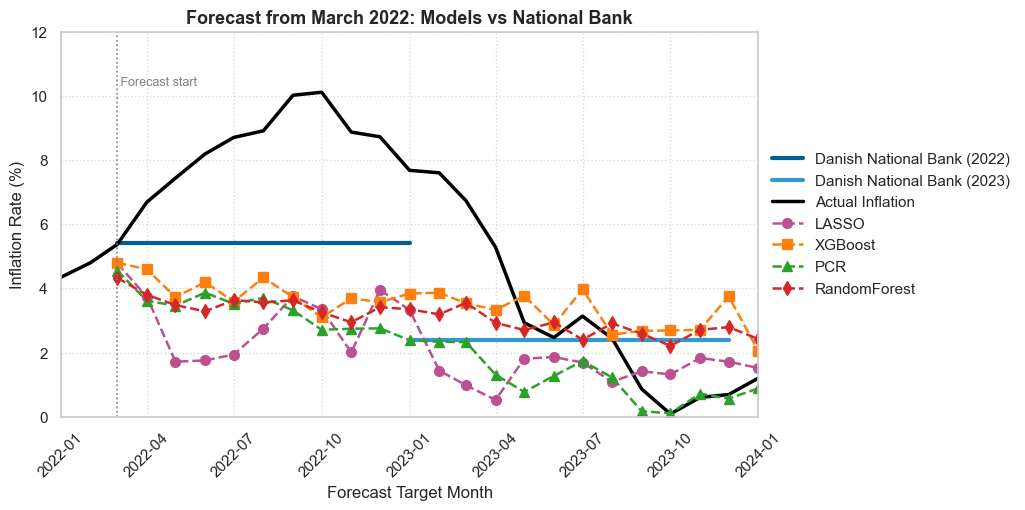

In [21]:
# Forecast origin
forecast_origin = "2022-03-01"

# Start figure
fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)

# Colors and marker styles for models
model_styles = {
    "LASSO":        {"color": "#bc5090", "marker": "o"},
    "XGBoost":      {"color": "#ff7f0e", "marker": "s"},
    "PCR":          {"color": "#2ca02c", "marker": "^"},
    "RandomForest": {"color": "#d62728", "marker": "d"}
}

# National Bank forecast
    # Extract National Bank forecast values
nb_2022 = nb_march_2022[nb_march_2022["Horisont"] == 0]["Forudsigelse"].values[0]
nb_2023 = nb_march_2022[nb_march_2022["Horisont"] == 1]["Forudsigelse"].values[0]

    # Create date intervals for each forecast period
nb_dates_2022 = pd.date_range(start="2022-03-01", end="2023-01-01", freq="MS")
nb_dates_2023 = pd.date_range(start="2023-01-01", end="2023-12-01", freq="MS")


# Plot National Bank forecasts divided into two periods
ax.plot(nb_dates_2022, [nb_2022] * len(nb_dates_2022),
        label="Danish National Bank (2022)", color="#005f99", linewidth=3.0)
ax.plot(nb_dates_2023, [nb_2023] * len(nb_dates_2023),
        label="Danish National Bank (2023)", color="#3399cc", linewidth=3.0)

# ✅ Actual inflation from 2012 to 2024
ax.plot(y.index, y.values,
        label="Actual Inflation",
        color="black",
        linewidth=2.5)

# Model forecasts
for model, style in model_styles.items():
    ax.plot(forecast_march["Date"], forecast_march[model],
            label=model,
            color=style["color"],
            linestyle="--",
            marker=style["marker"],
            markersize=7,
            markerfacecolor=style["color"],
            markeredgecolor=style["color"],
            linewidth=1.8)

# Forecast start marker
if forecast_origin:
    ax.axvline(pd.Timestamp(forecast_origin), color="gray", linestyle=":", linewidth=1.2)
    ax.text(pd.Timestamp(forecast_origin), ax.get_ylim()[1], " Forecast start",
            color="gray", fontsize=9, va="top", ha="left")

# Axis settings
ax.set_title("Forecast from March 2022: Models vs National Bank", fontsize=13, weight="bold")
ax.set_xlabel("Forecast Target Month")
ax.set_ylabel("Inflation Rate (%)")

# Set y-axis range based on max value
max_y = max(forecast_march[["LASSO", "XGBoost", "PCR", "RandomForest", "y_true"]].max().max(),
            y.max())
rounded_max = np.ceil(max_y + 1)
ax.set_ylim(0, rounded_max)
ax.set_yticks(np.arange(0, rounded_max + 1, 2))

# ✅ Limit visible date range: 2022 → 2024
ax.set_xlim(pd.Timestamp("2022-01-01"), pd.Timestamp("2024-01-01"))

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', rotation=45)
ax.grid(True, linestyle=":", alpha=0.7)

# Move legend to the right
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Save plot (optional)
# plt.savefig("forecast_march.png")
plt.show()


### **Forecast from September 2022**

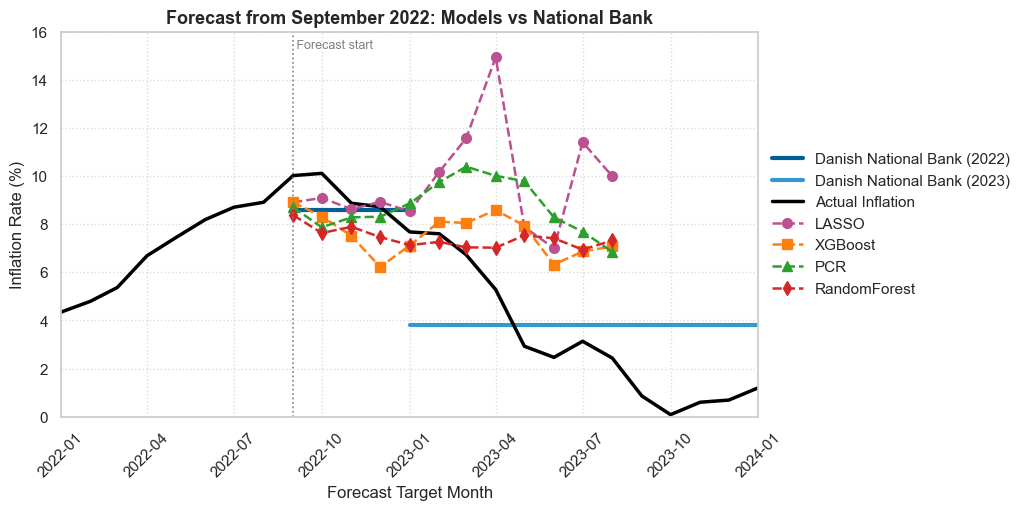

In [23]:
# Forecast origin
forecast_origin = "2022-09-01"

# Start figure
fig, ax = plt.subplots(figsize=(12, 5), constrained_layout=True)

# Colors and marker styles for models
model_styles = {
    "LASSO":        {"color": "#bc5090", "marker": "o"},
    "XGBoost":      {"color": "#ff7f0e", "marker": "s"},
    "PCR":          {"color": "#2ca02c", "marker": "^"},
    "RandomForest": {"color": "#d62728", "marker": "d"}
}

# National Bank forecast
# Extract National Bank forecast values
nb_sept_22 = nb_sept_2022[nb_sept_2022["Horisont"] == 0]["Forudsigelse"].values[0]
nb_sept_23 = nb_sept_2022[nb_sept_2022["Horisont"] == 1]["Forudsigelse"].values[0]

# Create date intervals for each forecast period
nb_sept_22_dates = pd.date_range(start="2022-09-01", end="2023-01-01", freq="MS")
nb_sept_23_dates = pd.date_range(start="2023-01-01", end="2024-01-01", freq="MS")


# Plot National Bank forecasts for two separate periods
ax.plot(nb_sept_22_dates, [nb_sept_22] * len(nb_sept_22_dates),
        label="Danish National Bank (2022)", color="#005f99", linewidth=3.0)
ax.plot(nb_sept_23_dates, [nb_sept_23] * len(nb_sept_23_dates),
        label="Danish National Bank (2023)", color="#3399cc", linewidth=3.0)

# ✅ Actual inflation
ax.plot(y.index, y.values,
        label="Actual Inflation",
        color="black",
        linewidth=2.5)

# Model forecasts
for model, style in model_styles.items():
    ax.plot(forecast_sept["Date"], forecast_sept[model],
            label=model,
            color=style["color"],
            linestyle="--",
            marker=style["marker"],
            markersize=7,
            markerfacecolor=style["color"],
            markeredgecolor=style["color"],
            linewidth=1.8)

# Forecast start marker
if forecast_origin:
    ax.axvline(pd.Timestamp(forecast_origin), color="gray", linestyle=":", linewidth=1.2)
    ax.text(pd.Timestamp(forecast_origin), ax.get_ylim()[1], " Forecast start",
            color="gray", fontsize=9, va="top", ha="left")

# Axis settings
ax.set_title("Forecast from September 2022: Models vs National Bank", fontsize=13, weight="bold")
ax.set_xlabel("Forecast Target Month")
ax.set_ylabel("Inflation Rate (%)")
max_y = max(forecast_sept[["LASSO", "XGBoost", "PCR", "RandomForest", "y_true"]].max().max(),
            y.max())
rounded_max = np.ceil(max_y + 1)
ax.set_ylim(0, rounded_max)
ax.set_yticks(np.arange(0, rounded_max + 1, 2))

# ✅ Limit visible date range: 2022 → 2024
ax.set_xlim(pd.Timestamp("2022-01-01"), pd.Timestamp("2024-01-01"))

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.tick_params(axis='x', rotation=45)
ax.grid(True, linestyle=":", alpha=0.7)

# Move legend to the right
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.75, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)

# Save figure (optional)
# plt.savefig("forecast_sept.png")
plt.show()


## 2.2 Forecast Evaluation

To ensure a fair comparison, we evaluate only the first 12 forecasted months from the March forecast, matching the full horizon of the September forecast.

In [26]:
forecast_march_12m = forecast_march[:12]

### **Forecast Erros: RMSE**

In [28]:
# Evaluate RMSE for forecasts from March and September
rmse_march = evaluate(forecast_march_12m, metric="RMSE")
rmse_sept = evaluate(forecast_sept, metric="RMSE")

# Create a DataFrame with models as index
RMSE_df = pd.DataFrame({
    "March 2022 Forecast": rmse_march,
    "September 2022 Forecast": rmse_sept
})

# Round the values for cleaner output
RMSE_df = RMSE_df.round(3)

# Display the results
RMSE_df

,March 2022 Forecast,September 2022 Forecast
LASSO,5.619,4.973
XGBoost,4.587,2.904
PCR,5.223,3.765
RandomForest,4.941,2.873
Danmarks_NB,3.633,2.031


### **Forecast Erros: MAE**

In [30]:
# Evaluate MAE for forecasts from March and September
mae_march = evaluate(forecast_march_12m, metric="MAE")
mae_sept = evaluate(forecast_sept, metric="MAE")

# Create a DataFrame with models as index
mae_df = pd.DataFrame({
    "March 2022 Forecast": mae_march,
    "September 2022 Forecast": mae_sept
})

# Round the values for cleaner output
mae_df = mae_df.round(3)

# Display the results
mae_df

,March 2022 Forecast,September 2022 Forecast
LASSO,5.318,3.817
XGBoost,4.273,2.474
PCR,4.946,3.160
RandomForest,4.704,2.295
Danmarks_NB,3.297,1.638
